# Transformations Tutorial #1: Coordinate Systems
## Introduction

This tutorial is about the transformation packages `LocalCoordinateSystem` class which describes the orientation and position of a Cartesian coordinate system towards another reference coordinate system.
The reference coordinate systems origin is always at $(0, 0, 0)$ and its orientation is described by the basis: $e_x = (1, 0, 0)$, $e_y = (0, 1, 0)$, $e_z = (0, 0, 1)$.

All coordinate systems used by WelDX are poistively oriented and follow the [right hand rule](https://en.wikipedia.org/wiki/Right-hand_rule)

## Imports

In [1]:
# enable interactive plots on Jupyterlab with ipympl and jupyterlab-matplotlib installed
# %matplotlib widget

In [2]:
# interactive plots
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

# plotting
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from weldx import LocalCoordinateSystem, WXRotation, MathematicalExpression, TimeSeries, Q_
import weldx.visualization as vs

## Construction

The initializer of the `LocalCoordinateSystem` class takes 2 parameters, the `orientation` and the `coordinates`. 
`orientation` is a 3x3 matrix. 
It can either be viewed as a rotation/reflection matrix or a set of normalized column vectors that represent the 3 basis vectors of the coordinate system inside of the reference system. 
The matrix needs to be [orthogonal](https://en.wikipedia.org/wiki/Orthogonal_matrix), otherwise, an exception is raised. 
`coordinates` is the position of the `LocalCoordinateSystem`'s origin inside the reference coordinate system.
The default parameters are the identity matrix and the zero vector. 
Hence, we get a system that is identical to the reference system if no parameter is passed to the constructor.

In [3]:
lcs_ref = LocalCoordinateSystem()

We now create some additional coordinate systems.
Note that coordinates can not be provided as pure numbers but as quantities.
This ensures that coordinates always have a unit.
If quantities are new to you, checkout [the documentation of the pint package](https://pint.readthedocs.io/en/0.10.1/tutorial.html).

In [4]:
lcs_01 = LocalCoordinateSystem(coordinates=Q_([2, 4, -1], "mm"))

rotation = WXRotation.from_euler("z", np.pi / 4).as_matrix()
lcs_02 = LocalCoordinateSystem(orientation=rotation, coordinates=Q_([0, 0, 3], "mm"))

`lcs_01` has the same orientation as the reference system but a different position.
`lcs_02` also risides at a position different from the origin.
Additionally, it is rotated around the z-axis by 45 degrees.
Below, a plot of the 3 coordinate systems is shown.

>Note that the corresponding code cell that produces the plot might be hidden since its content is not relevant for this tutorial.
This is also the case for all further plots.

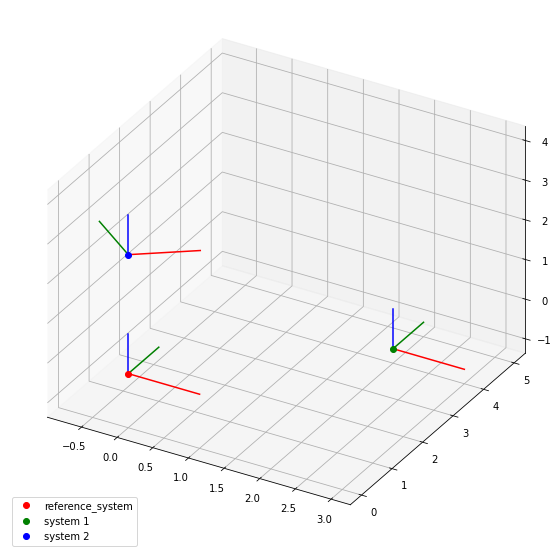

In [5]:
vs.plot_coordinate_systems(
    [
        (lcs_ref, {"color": "r", "label": "reference_system"}),
        (lcs_01, {"color": "g", "label": "system 1"}),
        (lcs_02, {"color": "b", "label": "system 2"}),
    ]
);

> **HINT:** Enabled interactive plots in the jupyter notebook version of this tutorial by uncommenting the code in the first cell. 
If you do so, you can rotate the plot by pressing the left mouse button and moving the mouse. 
This helps to understand how the different coordinate systems are positioned in the 3d space.

Since writing down a rotation matrix is usually not as straight forward as a translation vector, there are some additional methods to create a `LocalCoordinateSystem` that let you describe the systems orientation in a more intuitive way.
With the `from_axis_vectors` method, you specify orthogonal vectors that point into the same directions as the basis vectors of the new coordinate system.
2 vectors are usually sufficient since the third one can be computed automatically but you can also provide all three.

As an example take these 3 orthogonal vectors of arbitrary length:

In [6]:
a = [1, 2, 0]
b = [-6, 3, 0]
c = [0, 0, 5]

If they are orthogonal, we can use them te specify the orientation of a new `LocalCoordinateSystem`.
So let's try that:

In [7]:
lcs_03 = LocalCoordinateSystem.from_axis_vectors(x=a, y=b, z=c, coordinates=Q_([1, 1, 0], "mm"))

Seems like it worked.
If those vectors were't orthogoal, an exception would have been raised as the following example demonstrates:

In [8]:
w = [1,0,1]
try:
    LocalCoordinateSystem.from_axis_vectors(x=a, y=b, z=w, coordinates=Q_([1, 1, 0], "mm"))
except ValueError as e:
    print(f"The following exception was raised:\n{e}")

The following exception was raised:
Orientation vectors must be orthogonal


If we want the third vector to be calculated automatically, we pass just the two vectors we know:

In [9]:
lcs_04 = LocalCoordinateSystem.from_axis_vectors(x=a, z=c, coordinates=Q_([1, 1, 2], "mm"))

Because we used the vectors from before, the orientations of both coordinates should be identical.
Let's check that:

In [10]:
np.allclose(lcs_03.orientation, lcs_04.orientation)

True

Note that order matters here.
If we flipped the order of `a` and `c`, the calculated axis would point into the opposite direction because WelDX always calculates the missing axis in a way that the resulting system is positively oriented:

In [11]:
lcs_flipped_y = LocalCoordinateSystem.from_axis_vectors(x=c, z=a, coordinates=Q_([3, 3, -2], "mm"))

Here is a plot of the created coordinate systems:

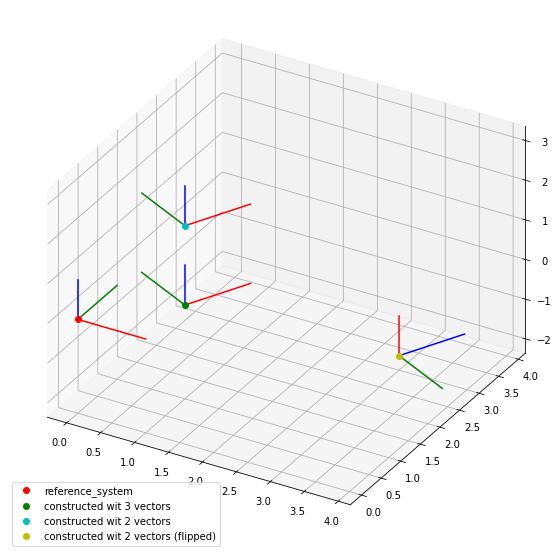

In [12]:
vs.plot_coordinate_systems(
    [
        (lcs_ref, {"color": "r", "label": "reference_system"}),
        (lcs_03, {"color": "g", "label": "constructed wit 3 vectors"}),
        (lcs_04, {"color": "c", "label": "constructed wit 2 vectors"}),
        (lcs_flipped_y, {"color": "y", "label":"constructed wit 2 vectors (flipped)"}),
    ]
);

Another method to create a `LocalCoordinateSystem` is `from_euler`. 
It utilizes a series of rotatios around the reference systems' coordinate axis to describe the new systems orientation towards the reference system. 
Its `sequence` parameter expects a string that determines the rotation sequence around the coordinate axes. 
For example `"xyz"` expresses that the first rotation is around the x-axis, the second around the y-axis and the last around the z-axis.
`angles` is either a scalar for a single rotation or a list for a series of rotations.
As the name suggests, it defines the rotation angles in the same order as the given sequence.
The parameter `degrees` should be set to `True` if the provided `angles` are in degrees. 
Here is a short example for a single rotation:

In [13]:
lcs_05 = LocalCoordinateSystem.from_euler(sequence="x", angles=90, degrees=True, coordinates=Q_([1, -1, 0], "mm"))

A rotation sequence would be defined as follows:

In [14]:
lcs_06 = LocalCoordinateSystem.from_euler(sequence="xy", angles=[90, 45], degrees=True, coordinates=Q_([2, -2, 0], "mm"))

The plot looks like this:

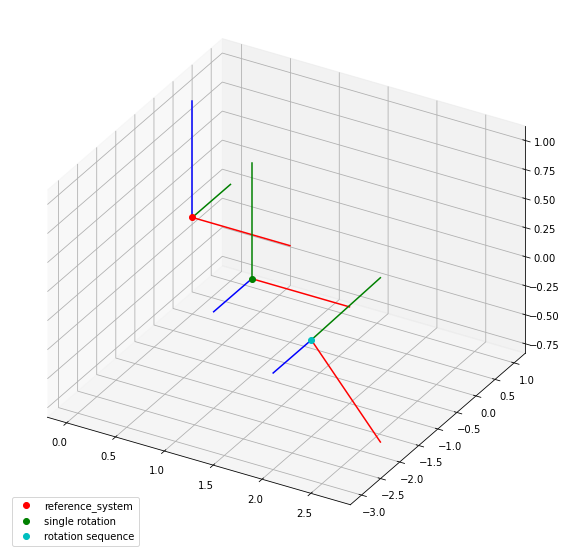

In [15]:
# create 3d plot
vs.plot_coordinate_systems(
    [
        (lcs_ref, {"color": "r", "label": "reference_system"}),
        (lcs_05, {"color": "g", "label": "single rotation"}),
        (lcs_06, {"color": "c", "label": "rotation sequence"}),
    ]
);

## Coordinate transformations

> **Important note:** This chapter covers rather low-level details. 
Coordinate transformations in WelDX should generally be done using the `CoordinateSystemManager` class ([click to open tutorial](transformations_02_coordinate_system_manager.ipynb)) since it is much easier to use and you do not need to remember some conventions mentioned below.
You won't have any problems in understanding WelDX if you skip this chapter entirely.

It is quite common that there exists a chain or tree-like dependency between coordinate systems. 
We might have a moving object with a local coordinate system that describes its position and orientation towards a fixed reference coordinate system. 
This object can have another object attached to it, with its position and orientation given in relation to its parent objects coordinate system. 
If we want to know the attached object coordinate system in relation to the reference coordinate system, we have to perform a coordinate transformation.

To avoid confusion about the reference systems of each coordinate system, we will use the following naming convention for the coordinate systems: `lcs_NAME_in_REFERENCE`. 
This is a coordinate system with the name "NAME" and its reference system has the name "REFERENCE". 
The only exception to this convention will be the reference coordinate system `lcs_ref`, which has no reference system.

The `LocalCoordinateSystem` class provides the `+` and `-` operators to change the reference system easily. 
The `+` operator will transform a coordinate system to the reference coordinate system of its current reference system:

~~~ python
lcs_child_in_ref = lcs_child_in_parent + lcs_parent_in_ref
~~~
As the naming of the variables already implies, the `+` operator should only be used if there exists a **child-parent relation** between the left-hand side and right-hand side system.
If two coordinate systems share a **common reference system**, the `-` operator transforms one of those systems into the other:

~~~ python
lcs_child_in_parent = lcs_child_in_ref - lcs_parent_in_ref
~~~

It is important to remember that this operation is in general not commutative since it involves matrix multiplication which is also not commutative. During those operations, the local system that should be transformed into another coordinate system is always located to the left of the `+` or `-` operator. You can also chain multiple transformations, like this:

~~~ python
lcs_A_in_C = lcs_A_in_B + lcs_B_in_ref - lcs_C_in_ref
~~~

Pythons operator associativity ([link](https://www.faceprep.in/python/python-operator-precedence-associativity/)) for the `+` and `-` operator ensures, that all operations are performed from left to right. So in the previously shown example, we first calculate an intermediate coordinate system `lcs_A_in_ref` (`lcs_A_in_B + lcs_B_in_ref`) without actually storing it to a variable and subsequently transform it to the reference coordinate system C (`lcs_A_in_ref - lcs_C_in_ref`). Keep in mind, that the intermediate results and the coordinate system on the right-hand side of the next operator must either have a child-parent relation (`+` operator) or share a common coordinate system (`-` operator), otherwise the transformation chain produces invalid results.

You can think about both operators in the context of a tree-like graph structure where all dependency chains lead to a common root coordinate system. The `+` operator moves a coordinate system 1 level higher and closer to the root. Since its way to the root leads over its parent coordinate system, the parent is the only valid system than can be used on the right-hand side of the `+` operator. The `-` operator pushes a coordinate system one level lower and further away from the root. It can only be pushed one level deeper if there is another coordinate system connected to its parent system.

> TODO: Add pictures


## Invert method

The `invert` method calculates how a parent coordinate system is positioned and oriented in its child coordinate system:

~~~ python
lcs_child_in_parent = lcs_parent_in_child.invert()
~~~

Here is a short example with visualization:

In [16]:
lcs_child_in_parent = LocalCoordinateSystem.from_euler(sequence="xy", angles=[90, 45], degrees=True, coordinates=Q_([2, 3, 0], "mm"))

lcs_parent_in_child = lcs_child_in_parent.invert()

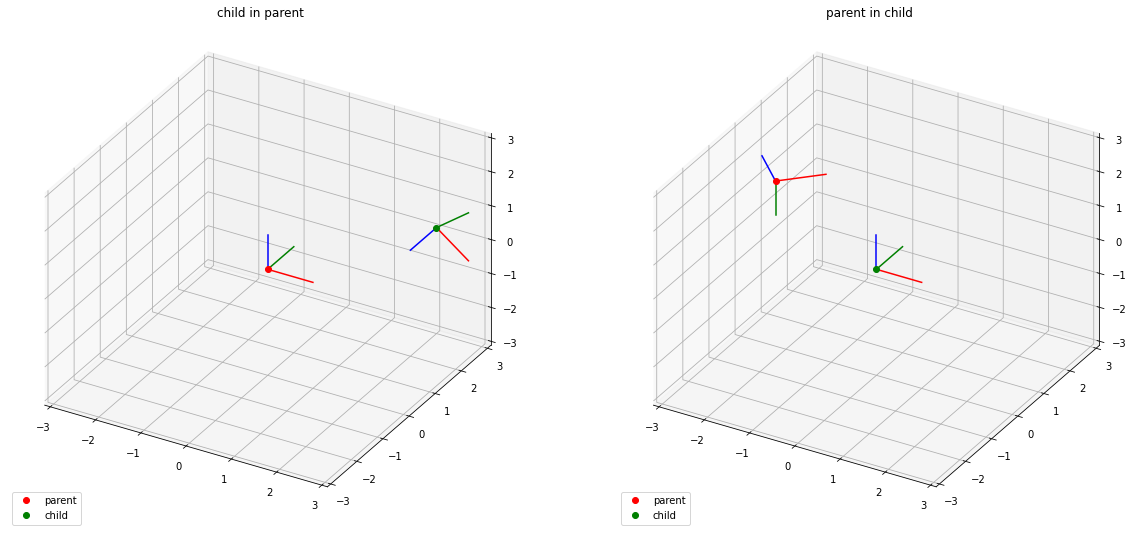

In [17]:
_, (ax_invert_0, ax_invert_1) = vs.new_3d_figure_and_axes(num_subplots=2, width=1000)

# left plot
vs.plot_coordinate_systems(
    [
        (lcs_ref, {"color": "r", "label": "parent"}),
        (lcs_child_in_parent, {"color": "g", "label": "child"}),
    ],
    axes=ax_invert_0,
    limits=(-3, 3),
    title="child in parent",
)

# right plot
vs.plot_coordinate_systems(
    [
        (lcs_parent_in_child, {"color": "r", "label": "parent"}),
        (lcs_ref, {"color": "g", "label": "child"}),
    ],
    axes=ax_invert_1,
    limits=(-3, 3),
    title="parent in child",
);

## Time dependency

The orientation and position of a `LocalCoordinateSystem` towards their reference system might vary in time.
For example, in a welding process the position of the torch towards the specimen is changing constantly. 
The `LocalCoordinateSystem` provides an interface for such cases. 
All previously shown construction methods also provide the option to pass a `time` parameter.

To create a time-dependent system, you have to provide a list of time values. 
There are several time formats supported.
A list of the supported formats can be found in the [documentation of the generalized `Time` class](https://weldx.readthedocs.io/en/latest/_autosummary/weldx.Time.html#weldx.Time).

If you use the `time` parameter, you also need to provide the extra data for the `orientation` and/or `coordinates` to the construction method. 
One way to do this is by provide an array of coordinate vectors or orientation matrices with the same number of elements as there are time values. 
For example: If you want to create a moving coordinate system with 2 timestamps, you can do it by like this:

In [18]:
time = ["2010-02-01", "2010-02-02"]

orientation_mov = [[0, -1, 0], [1, 0, 0], [0, 0, 1]]
coordinates_mov = Q_([[-3, 0, 0], [0, 0, 2]], "mm")

lcs_mov_in_ref = LocalCoordinateSystem(
    orientation=orientation_mov, coordinates=coordinates_mov, time=time
)

Note that the coordinates are now a 2-dimensional array with two coordinate vectors while the orientation is still a single matrix and therefore constant.

A coordinate system with varying orientation between 2 timestamps using the `from_axis_vectors` can be defined very similar:

In [19]:
x_vecs = [[1, 0, 0], [0, -1, 0]]
y_vecs = [[0, 1, 0], [1, 0, 0]]
coordinates_rot = Q_([1, 0, 2], "mm")

lcs_rot_in_ref = LocalCoordinateSystem.from_axis_vectors(
    x=x_vecs, y=y_vecs, coordinates=coordinates_rot, time=time
)

Here the individual vectors are arrays.

A rotating and moving coordinate system defined with the `from_euler` method is shown in the next code section:

In [20]:
angles = [[25, 45], [135,90]]
coordinates_movrot = Q_([[0, 3, 0], [-2, 3, 2]], "mm")

lcs_movrot_in_ref = LocalCoordinateSystem.from_euler(
    sequence="xy", angles=angles, degrees=True, coordinates=coordinates_movrot, time=time
)

Here is a visualization of the created coordinate systems at the two different times:

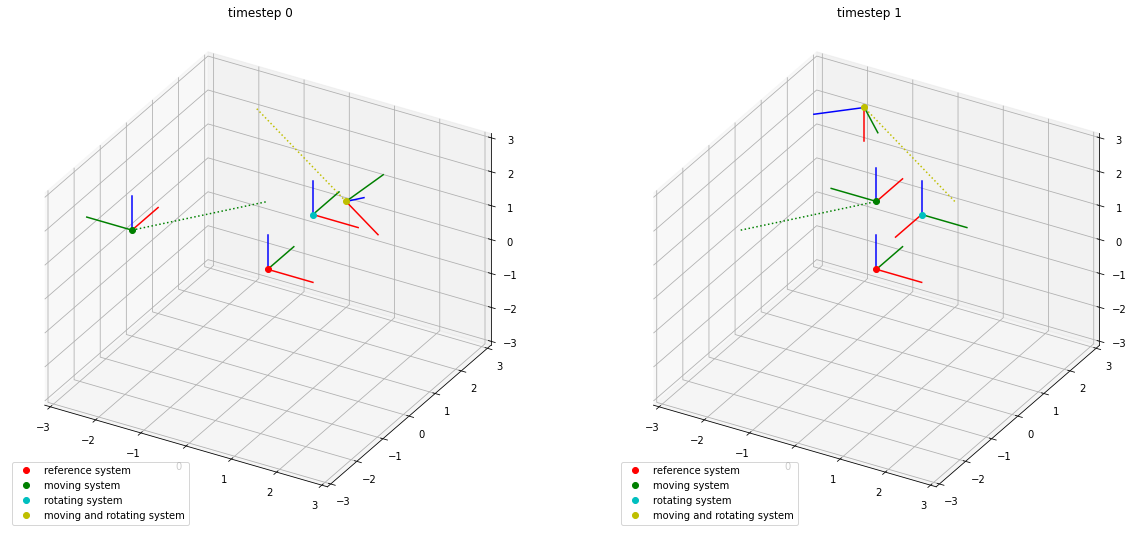

In [21]:
# plot coordinate systems
_, axes_array = vs.new_3d_figure_and_axes(num_subplots=2, width=1000)

for i, ax in enumerate(axes_array):
    vs.plot_coordinate_systems(
        [
            (lcs_ref, {"color": "r", "label": "reference system"}),
            (lcs_mov_in_ref, {"color": "g", "label": "moving system"}),
            (lcs_rot_in_ref, {"color": "c", "label": "rotating system"}),
            (lcs_movrot_in_ref, {"color": "y", "label": "moving and rotating system"}),
        ],
        axes=ax,
        limits=(-3, 3),
        title=f"timestep {i}",
        time_index=i,
    )

todo: write text and sort in 

## Time interpolation

It is also possible, to interpolate a coordinate system's orientations and coordinates in time by using the `interp_time` function.
You have to pass it a single or multiple target times for the interpolation.
The same time formats that are compatible with the different construction methods can be used here too.

Alternatively, you can pass another `LocalCoordinateSystem` which provides the target timestamps.
The return value of this function is a new `LocalCoordinateSystem` with interpolated orientations and coordinates.
In case that a target time for the interpolation lies outside of the `LocalCoordinateSystem`s' time range, the boundary value is broadcasted.

Here is an example:

In [22]:
time = ["2010-02-02", "2010-02-07"]
time_interp = ["2010-02-01", "2010-02-03", "2010-02-04", "2010-02-05", "2010-02-06", "2010-02-11"]

coordinates_tdp = Q_([[0, 3, 0], [-2, 3, 2]], "mm")
angles_tdp = [0, 90]

lcs_tdp_in_ref = LocalCoordinateSystem.from_euler(
    sequence="z", angles=angles_tdp, degrees=True, coordinates=coordinates_tdp, time=time
)

lcs_interp_in_ref = lcs_tdp_in_ref.interp_time(time_interp)

Here is a visual representation of the original and the interpolated system:

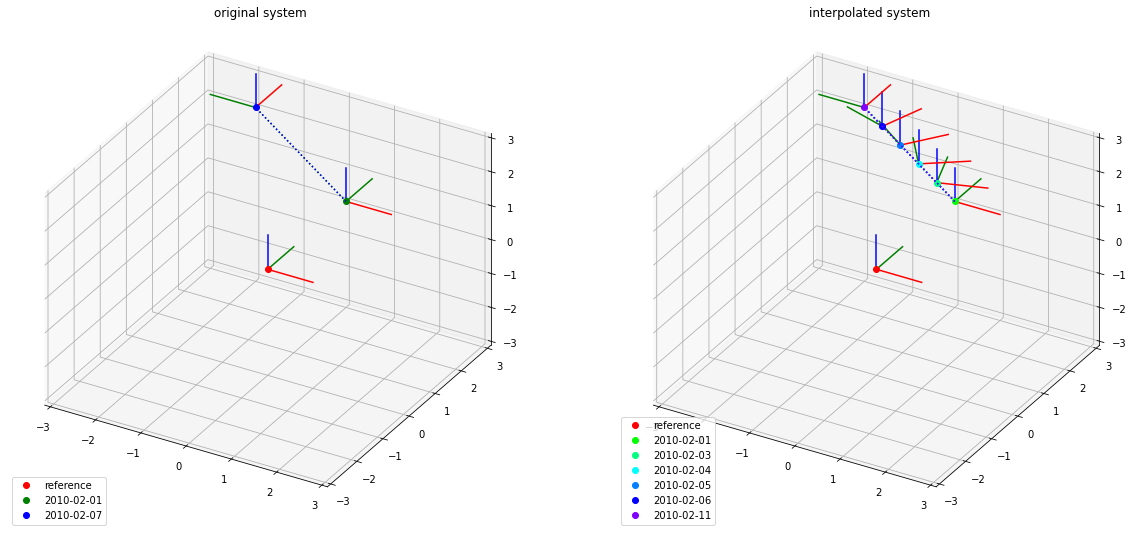

In [23]:
# plot coordinate systems
_, (ax_0_interp, ax_1_interp) = vs.new_3d_figure_and_axes(num_subplots=2, width=1000)

# original systems
vs.plot_coordinate_systems(
    [
        (lcs_ref, {"color": "r", "label": "reference"}),
        (lcs_tdp_in_ref, {"color": "g", "label": "2010-02-01", "time_index": 0}),
        (lcs_tdp_in_ref, {"color": "b", "label": "2010-02-07", "time_index": 1}),
    ],
    axes=ax_0_interp,
    limits=(-3, 3),
    title="original system",
)


# interpolated systems
colors = [[0, 1, 0], [0, 1, 0.5], [0, 1, 1], [0, 0.5, 1], [0, 0, 1], [0.5, 0, 1]]
plot_data = [
    (lcs_interp_in_ref, {"color": colors[i], "label": time_interp[i], "time_index": i})
    for i in range(len(time_interp))
]
plot_data = [(lcs_ref, {"color": "r", "label": "reference"}), *plot_data]

vs.plot_coordinate_systems(
    plot_data, axes=ax_1_interp, limits=(-3, 3), title="interpolated system"
);

As you can see, the time values `"2010-02-01"` and `"2010-02-11"`, which lie outside the original range from `"2010-02-02"` and `"2010-02-07"`,  still get valid values due to the broadcasting across time range boundaries. 
The intermediate coordinates and orientations are interpolated as expected.

> **Note:** 
Using the `+` and `-` operators with time dependent systems obeys the following rules:
>- If the left-hand side system has a time component, the data of the right-hand side system will be interpolated to the same times, before the previously shown operations are performed per point in time. 
>- In case, that the left-hand side system has no time component, but the right-hand side does, the resulting system has the same time components as the right-hand side system.

## Mathematical Expressions for time dependent coordinates

Another type that can be used to create a `LocalCoordinateSystem` is the `TimeSeries`.
This class represents time-dependent data and can either be created with explicit values or a `MathematicalExpression` ([click to get to API doc](https://weldx.readthedocs.io/en/latest/_autosummary/weldx.MathematicalExpression.html)).
Therefore, we can describe time dependent coordinate systems also with mathematical expressions (Note that only coordinates support the `TimeSeries` class at the moment).

We will give you just a short example without much explanation here, but if you want to learn how to create a valid `TimeSeries` using mathematical expressions, checkout [the tutorial about this class](timeseries_01.ipynb). 

The following systems z-position will change quadratically with time while it moves at a constant speed into the x-direction: 

In [24]:
expression = "a*t^2 + b*t + c"
parameters = dict(a=Q_([0,0,0.2],"mm/s^2"), b=Q_([1,0, 0], "mm/s"), c=Q_([-2,-2, -2], "mm"))

me = MathematicalExpression(expression=expression, parameters=parameters)
ts = TimeSeries(me)

lcs_expr = LocalCoordinateSystem(coordinates=ts)

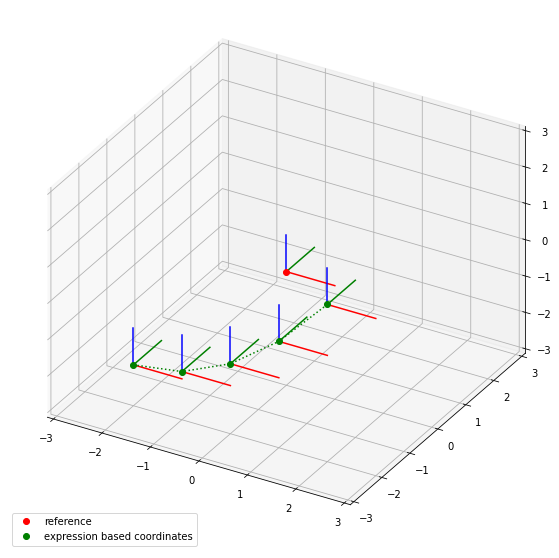

In [25]:
# plot coordinate systems
_, ax_dsx = vs.new_3d_figure_and_axes()

lcs_expr_int = lcs_expr.interp_time(Q_([i for i in range(5)], "s"))
# first timestep
vs.plot_coordinate_systems(
    [
        (lcs_ref, {"color": "r", "label": "reference"}),
        (lcs_expr_int, {"color": "g", "label": "expression based coordinates"}),
    ],
    axes=ax_dsx,
    limits=(-3, 3),
);

## Transformation of spatial data

The `LocalCoordinateSystem` only defines how the different coordinate systems are oriented towards each other. 
If you want to transform spatial data which is defined in one coordinate system (for example specimen geometry/point cloud) you have to use the `CoordinateSystemManager`, which is discussed in the next tutorial or do the transformation manually.
For the manual transformation, you can get all you need from the `LocalCoordinateSystem` using its accessor properties:

~~~
orientation = lcs_a_in_b.orientation
coordinates = lcs_a_in_b.coordinates
~~~

The returned data is an `xarray.DataFrame`. 
In case you are not used to work with this data type, you can get a `numpy.ndarray` by simply using their `data` property:

~~~
orientation_numpy = lcs_a_in_b.orientation.data
coordinates_numpy = lcs_a_in_b.coordinates.data
~~~

Keep in mind, that you actually get an array of matrices (`orientation`) and vectors (`coordinates`) if the corresponding component is time dependent. 
The transformation itself is done by the equation:

$$v_b = O_{ab} \cdot v_a + c_{ab}$$

where $v_a$ is a data point defined in coordinate system `a`, $O_{ab}$ is the orientation matrix of `a` in `b`, $c_{ab}$ the coordinates of `a` in `b` and $v_b$ the transformed data point.


Here is a short example that transforms the points of a square from one coordinate system to another.
First we create a set of points with the coordinates ment to be defined in the reference system:

In [26]:
data = np.array([[-1, 1, 0], [1, 1, 0], [1, -1, 0], [-1, -1, 0], [-1, 1, 0]], dtype=float)

points_in_ref = Q_(data.transpose(),"mm")

Now we create the target system:

In [27]:
lcs_target_in_ref = LocalCoordinateSystem.from_euler(sequence="zy", angles=[90,-45], degrees=True, coordinates=Q_([2, -2, 0], "mm"))

For the transformation from the reference system to the target system we actually need the orientation and coordinates of the inverted target system:

In [28]:
lcs_ref_in_target = lcs_target_in_ref.invert()
t_mat = lcs_ref_in_target.orientation.data
t_vec = lcs_ref_in_target.coordinates.data

Now we use the formula we discussed earlier:

In [29]:
points_in_target = (np.matmul(t_mat, points_in_ref)+ t_vec[:, np.newaxis])

Note that we needed to broadcast the values of `t_vec` using `[:, np.newaxis]` because we are not working with a single point but an array of points.
Since we now have the data available in both coordinate systems, we can create the following plots:

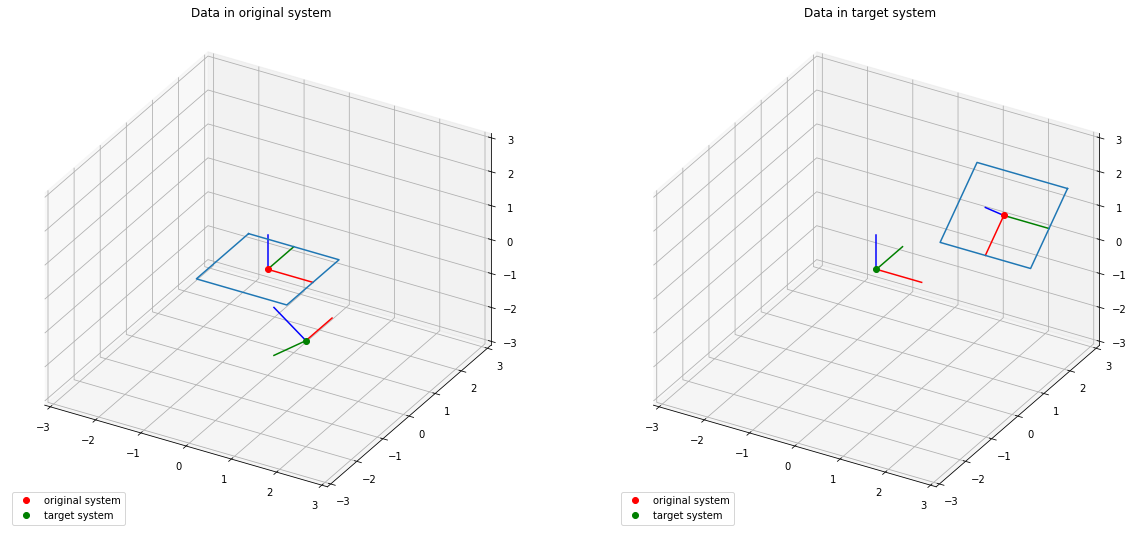

In [30]:
# plot coordinate systems
_, (ax_0_trans, ax_1_trans) = vs.new_3d_figure_and_axes(num_subplots=2, width=1000)

# first plot
vs.plot_coordinate_systems(
    [
        (lcs_ref, {"color": "r", "label": "original system"}),
        (lcs_target_in_ref, {"color": "g", "label": "target system"}),
    ],
    axes=ax_0_trans,
    limits=(-3, 3),
    title="Data in original system",
)
ax_0_trans.plot(points_in_ref[0].m, points_in_ref[1].m, points_in_ref[2].m)


# second plot
vs.plot_coordinate_systems(
    [
        (lcs_ref_in_target, {"color": "r", "label": "original system"}),
        (lcs_ref, {"color": "g", "label": "target system"}),
    ],
    axes=ax_1_trans,
    limits=(-3, 3),
    title="Data in target system",
)
ax_1_trans.plot(points_in_target[0].m, points_in_target[1].m, points_in_target[2].m);

## Internal xarray structure

The local coordinate system and many other components of the WelDX package use xarray data frames internally. 
So it is also possible to pass `xarray.DataArray`s to a lot of methods. 
However, they need a certain structure which will be described here. 
If you are not familiar with the xarray package, you should first read the [documentation](http://xarray.pydata.org/en/stable/).

To pass a `xarray.DataArray` as coordinate to a `LocalCoordinateSystem`, it must at least have a dimension `c`. 
It represents the location in 3d space of the coordinate system and must always be of length 3. 
Those components must be named coordinates of the data frame (`coords={"c": ["x", "y", "z"]}`). 
An optional dimension is `time`. 
It can be of arbitrary length, but the timestamps must be added as coordinates.

The same conventions that are used for the coordinates also apply to the orientations. 
Additionally, they must have another dimension `v` of length 3, which are enumerated (`"v": [0, 1, 2]`). 
`c` and `v` are the rows and columns of the orientation matrix.

Here is an example.
Time dependent coordinates are defined as follows:

In [31]:
time = pd.TimedeltaIndex([0, 5], "D")
coordinates_q = Q_([[0, 3, 0], [-2, 3, 2]], "mm")

coordinates_da = xr.DataArray(
    data=coordinates_q,
    dims=["time", "c"],
    coords={"time": time, "c": ["x", "y", "z"]},
)

The definition of time dependent orientations is quiete similar:

In [32]:
orientation_q = [
    [[1, 0, 0], [0, 1, 0], [0, 0, 1]],
    [[0, -1, 0], [1, 0, 0], [0, 0, 1]],
]

orientation_da = xr.DataArray(
    data=orientation_q,
    dims=["time", "c", "v"],
    coords={"time": time, "c": ["x", "y", "z"], "v": [0, 1, 2]},
)

Now we can create a new `LocalCoordinateSystem`:

In [33]:
lcs_xr = LocalCoordinateSystem(orientation=orientation_da, coordinates=coordinates_da)

Here is the resulting plot:

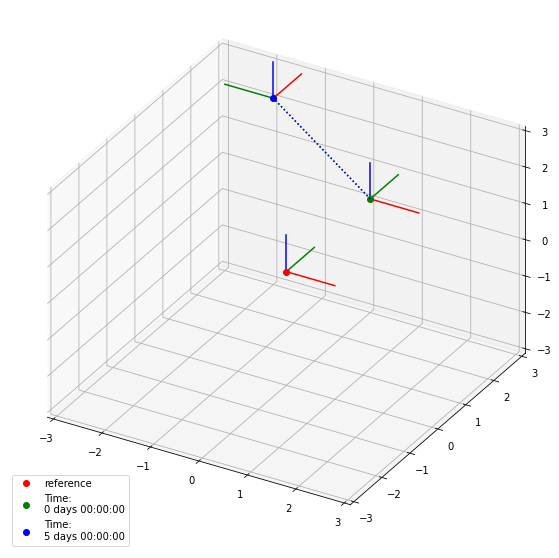

In [34]:
# plot coordinate systems
_, ax_dsx = vs.new_3d_figure_and_axes()

# first timestep
vs.plot_coordinate_systems(
    [
        (lcs_ref, {"color": "r", "label": "reference"}),
        (lcs_xr, {"color": "g", "label": str(lcs_xr.time[0]), "time_index": 0}),
        (lcs_xr, {"color": "b", "label": str(lcs_xr.time[1]), "time_index": 1}),
    ],
    axes=ax_dsx,
    limits=(-3, 3),
);

The `weldx.utility` package contains two utility functions to create xarray data frames that can be passed as `orientation` and `coordinates` to an `LocalCoordinateSystem`.
They are named `xr_3d_vector` and `xr_3d_matrix`. 
Here are the links to the corresponding API documentation [for vectors](https://weldx.readthedocs.io/en/latest/_autosummary/weldx.util.xr_3d_vector.html#weldx.util.xr_3d_vector) and [matrices](https://weldx.readthedocs.io/en/latest/_autosummary/weldx.util.xr_3d_matrix.html#weldx.util.xr_3d_matrix).